In [55]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
import numpy as np
import matplotlib.pyplot as plt

# from tqdm.notebook import tqdm
from tqdm import tqdm
from functions import (
    get_lin_var,
    get_lin_var_short_time,
    get_theo_var_l_two_time,
)
from functions import get_eq_times
from functions import SolverManager, EigenvectorManager, SimulationManager

from setup import setup_matplotlib, one_col, std_height, two_col
from timeit import default_timer as timer

setup_matplotlib()

np.random.seed(42)

In [57]:
version = 2

s = 1
D = s**2 / 2
max_t = 10
ntau = 2  # 3
# dx = 0.3
N_x = 61  # 25
eq_perc = 0.75
hist_sigma = 4
avg_part = 4
force = "linear"

if force == "linear":
    a = 0.0
    b = 1.0
elif force == "general":
    a = 1.0
    b = 1.0

f = 15
N_p = 2_000
N_loop = 10

ntau_sim = f * ntau

ltaus = np.concatenate(([0, 0.02, 0.05, 0.1], np.arange(0.2, 2.2, 0.1)))
sbs = np.empty(len(ltaus))
sim_vars = np.empty((len(ltaus), 4))
sim_eq_time = np.empty((len(ltaus), 2))

# sim_hist_vars = np.empty((len(ltaus), 4))
# sim_hist_eq_time = np.empty((len(ltaus), 2))

num_vars = np.empty((len(ltaus), 4))
num_eq_time = np.empty((len(ltaus), 2))

non_div_taus = (
    ltaus[ltaus < np.arccos(-a / b) / np.sqrt(b**2 - a**2)] if a < b else ltaus
)

eig_vars = np.empty((len(non_div_taus), 2))

In [58]:
test_ltaus = np.arange(0, non_div_taus[-1], 0.025)
exact_eqtimes = np.array([get_eq_times(ltau, D, eq_perc, a, b) for ltau in test_ltaus])

In [59]:
my_sim_manager = SimulationManager()

for i, ltau in enumerate(tqdm(ltaus)):
    ldt = ltau / ntau_sim if ltau > 0 else ltaus[1] / ntau_sim
    N_t = int(max_t / ldt) + 1

    ntau_arg = ntau_sim if ltau > 0 else 0

    res = my_sim_manager.run(
        N_p=N_p,
        N_loop=N_loop,
        N_t=N_t,
        N_x=N_x,
        ntau=ntau_arg,
        s=s,
        dt=ldt,
        x_0=0,
        force=force,
        hist_sigma=hist_sigma,
    )

    sim_ts = np.arange(0, (N_t + ntau_sim)) * ldt - ltau

    sim_var = res["sim_var"]
    # sim_hist_var = res["sim_hist_var"]
    x_s = res["x_s"]
    sbs[i] = -x_s[0]

    mean_sim_vars = np.mean(sim_var[:, -N_t // avg_part :], axis=1)
    sim_vars[i] = (
        np.mean(mean_sim_vars),
        np.std(mean_sim_vars) / np.sqrt(N_loop),
        np.min(np.mean(sim_var[:, -N_t // avg_part :], axis=0)),
        np.max(np.mean(sim_var[:, -N_t // avg_part :], axis=0)),
    )

    mean_s_eq = sim_ts[
        np.argmin((eq_perc * mean_sim_vars[:, None] - sim_var) ** 2, axis=1)
    ]
    sim_eq_time[i] = (np.mean(mean_s_eq), np.std(mean_s_eq) / np.sqrt(N_loop))

    # mean_sim_hist_var = np.mean(sim_hist_var[:, -N_t // avg_part :], axis=1)
    # sim_hist_vars[i] = (
    #     np.mean(mean_sim_hist_var),
    #     np.std(mean_sim_hist_var) / np.sqrt(N_loop),
    #     np.min(np.mean(sim_hist_var[:, -N_t // avg_part :], axis=0)),
    #     np.max(np.mean(sim_hist_var[:, -N_t // avg_part :], axis=0)),
    # )

    # mean_sh_eq = sim_ts[
    #     np.argmin((eq_perc * mean_sim_hist_var[:, None] - sim_hist_var) ** 2, axis=1)
    # ]
    # sim_hist_eq_time[i] = (np.mean(mean_sh_eq), np.std(mean_sh_eq) / np.sqrt(N_loop))

100%|██████████| 24/24 [00:00<00:00, 420.12it/s]


In [60]:
my_num_manager = SolverManager()

for i, ltau in enumerate(tqdm(ltaus)):
    ldt = ltau / ntau if ltau > 0 else ltaus[1] / ntau
    N_t = int(max_t / ldt) + 1

    ts = np.arange(0, N_t) * ldt

    sb = sbs[i]

    res = my_num_manager.run(
        N_t=N_t,
        N_x=N_x,
        sb=sb,
        ntau=ntau if ltau > 0 else 0,
        s=s,
        dt=ldt,
        x_0=0,
        force=force,
        version=version,
    )

    num_var = res["num_var"]

    mean_num_var = np.mean(num_var[-N_t // avg_part :])
    num_vars[i] = (
        mean_num_var,
        0,
        np.min(num_var[-N_t // avg_part :]),
        np.max(num_var[-N_t // avg_part :]),
    )
    num_eq_time[i] = ts[np.argmin((eq_perc * mean_num_var - num_var) ** 2)]

100%|██████████| 24/24 [00:00<00:00, 783.71it/s]


In [61]:
eigen_manager = EigenvectorManager()

for i, ltau in enumerate(tqdm(non_div_taus)):
    ldt = ltau / ntau if ltau > 0 else ltaus[1] / ntau
    sb = sbs[i]

    if ltau > 0:
        res = eigen_manager.run(
            N_x=N_x, sb=sb, ntau=ntau, s=s, dt=ldt, force=force, version=version
        )
    else:
        res = eigen_manager.run(
            N_x=N_x, sb=sb, ntau=0, s=s, dt=ldt, force=force, version=version
        )

    eig_vars[i] = (res["eig_var"], 0)

100%|██████████| 18/18 [00:00<00:00, 609.40it/s]


In [62]:
short_time_approx_var = get_lin_var_short_time(non_div_taus, a, b, s)
exact_sol = get_lin_var(non_div_taus, a, b, s)
exact_sol_times = np.linspace(0, max_t, 1000)
exact_sol_dyn_raw = np.stack([
    get_theo_var_l_two_time(exact_sol_times, tau, D, a=a, b=b)[-len(exact_sol_times)//avg_part:]
    for tau in ltaus
])
exact_sol_dyn = np.stack((
    np.nanmean(exact_sol_dyn_raw, axis=1),
    np.zeros(exact_sol_dyn_raw.shape[0]),
    np.nanmin(exact_sol_dyn_raw, axis=1),
    np.nanmax(exact_sol_dyn_raw, axis=1),
)).T

/tmp/ipykernel_19310/380099266.py:9: RuntimeWarning: Mean of empty slice
  np.nanmean(exact_sol_dyn_raw, axis=1),
/tmp/ipykernel_19310/380099266.py:11: RuntimeWarning: All-NaN slice encountered
  np.nanmin(exact_sol_dyn_raw, axis=1),
/tmp/ipykernel_19310/380099266.py:12: RuntimeWarning: All-NaN slice encountered
  np.nanmax(exact_sol_dyn_raw, axis=1),


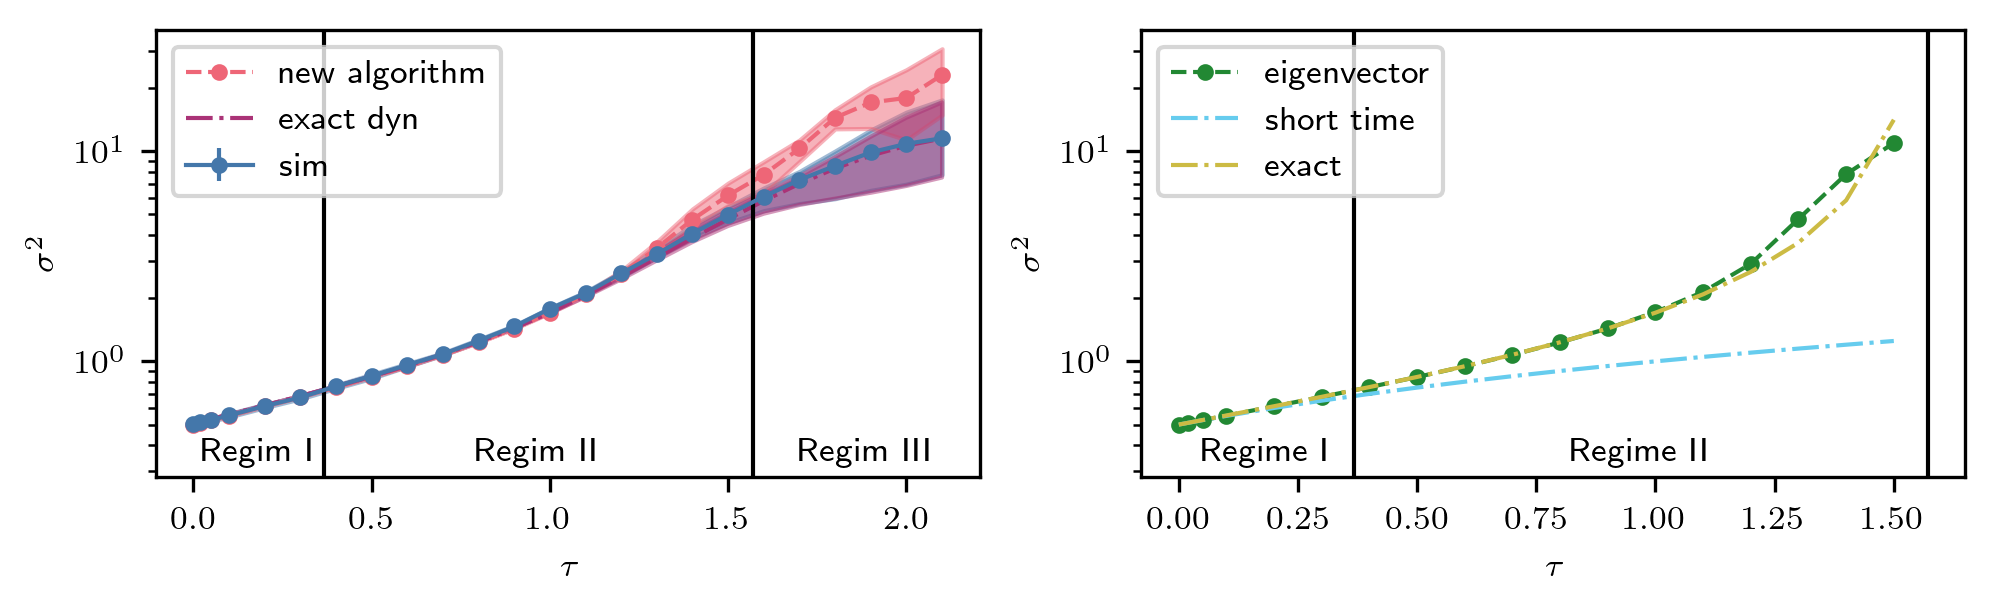

In [63]:
plt.figure(figsize=(two_col, std_height))
ax = plt.subplot(121)
if force == 'linear':
    plt.yscale("log")
plt.errorbar(
    ltaus, sim_vars[:, 0], sim_vars[:, 1], ls="-", marker=".", color="C0", label="sim"
)
# plt.errorbar(ltaus,sim_hist_vars[:,0],sim_hist_vars[:,1],marker='.', label='hist-sim')
plt.fill_between(ltaus, sim_vars[:, 2], sim_vars[:, 3], alpha=0.5, color="C0")
plt.plot(ltaus, num_vars[:, 0], marker=".", ls="--", color="C1", label="new algorithm")
plt.fill_between(ltaus, num_vars[:, 2], num_vars[:, 3], alpha=0.5, color="C1")
plt.plot(ltaus, exact_sol_dyn[:,0], "-.", color="C5", label="exact dyn")
plt.fill_between(ltaus, exact_sol_dyn[:, 2], exact_sol_dyn[:, 3], alpha=0.5, color="C5")

# plt.ylim(3e-1, 25)
# plt.xlim(0, 2.1)
if force == "linear":
    plt.ylim(0.7*plt.ylim()[0], plt.ylim()[1])
    y = plt.ylim()[0]*1.3
    plt.vlines([1 / np.e, np.pi / 2], *plt.ylim(), color="black")
    plt.text(0.5 * 1 / np.e, y, "Regim I", ha="center", va="center")
    plt.text(0.5 * (1 / np.e + np.pi / 2), y, "Regim II", ha="center", va="center")
    plt.text(
        0.5 * (np.pi / 2 + plt.xlim()[1]), y, "Regim III", ha="center", va="center"
    )
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\sigma^2$")
ylim = plt.ylim()
# auflösungslimit
# plt.hlines((x_s[-1]/3)**2, *plt.xlim())

ax = plt.subplot(122)
if force == 'linear':
    plt.yscale("log")
plt.ylim(*ylim)
# plt.errorbar(
#     ltaus,
#     num_vars[:, 0] / sim_vars[:, 0],
#     yerr=np.sqrt(
#         (num_vars[:, 1] / sim_vars[:, 0]) ** 2
#         + (num_vars[:, 0] / sim_vars[:, 0] ** 2 * sim_vars[:, 1]) ** 2
#     ),
#     marker=".",
#     color="C1",
# )
plt.plot(
    non_div_taus,
    eig_vars[:, 0],
    marker=".",
    ls="--",
    color="C2",
    label="eigenvector",
)
if force == "linear":
    plt.plot(non_div_taus, short_time_approx_var, "-.", color="C4", label="short time")
plt.plot(non_div_taus, exact_sol, "-.", color="C3", label="exact")

if force == "linear":
    # plt.ylim(0.7*plt.ylim()[0], plt.ylim()[1])
    y = plt.ylim()[0]*1.3
    plt.vlines([1 / np.e, np.pi / 2], *plt.ylim(), color="black")
    plt.text(0.5 * 1 / np.e, y, "Regime I", ha="center", va="center")
    plt.text(0.5 * (1 / np.e + np.pi / 2), y, "Regime II", ha="center", va="center")
    # plt.text(
    #     0.5 * (np.pi / 2 + plt.xlim()[1]), y, "Regime III", ha="center", va="center"
    # )



plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\sigma^2$")
# plt.ylabel(r"deviation")


plt.tight_layout()
plt.savefig(f'graphics/x2variance_v{version}_{force}.pdf')

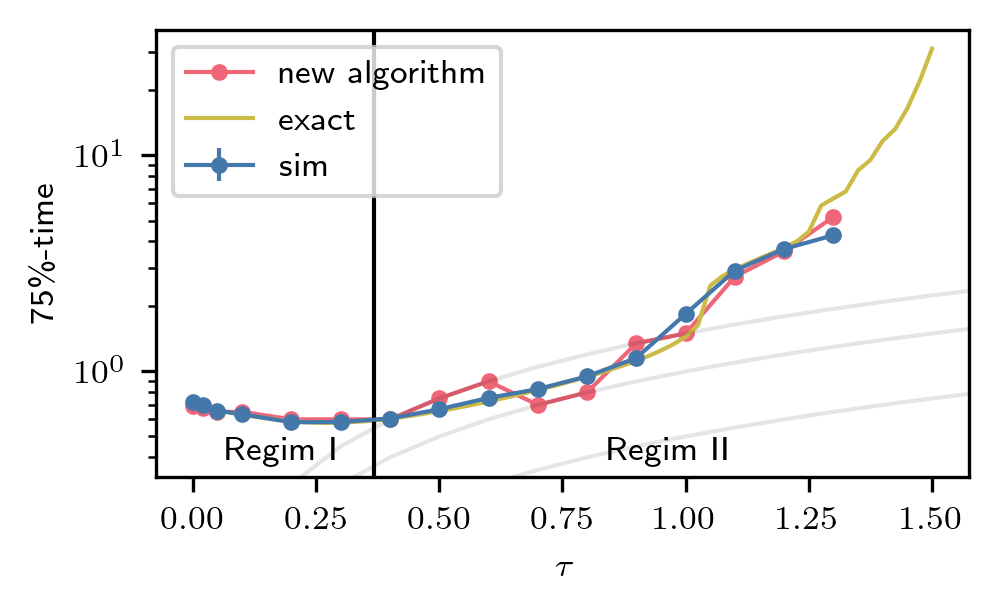

In [67]:
# Only if system was able to reach steady state
eq_perc = 0.75
eq_f = 0.75
q_f = np.log(1 - eq_f) / np.log(1 - eq_perc)
max_t_eq = test_ltaus[(exact_eqtimes * q_f) < (max_t - max_t/avg_part)][-1]
cond = ltaus <= max_t_eq
plt.plot(ltaus[cond], num_eq_time[cond, 0], marker=".", color="C1", label="new algorithm")
# plt.errorbar(ltaus, *sim_hist_eq_time.T, marker ='.', label = 'hist-sim')
plt.errorbar(ltaus[cond], *sim_eq_time[cond].T, marker=".", color="C0", label="sim")
plt.plot(test_ltaus, exact_eqtimes, color="C3", label="exact")

plt.yscale("log")
# plt.ylim(3e-1, 2e1)
if force == "linear":
    plt.ylim(0.7*plt.ylim()[0], plt.ylim()[1])
    y = plt.ylim()[0]*1.3
    plt.vlines([1 / np.e], *plt.ylim(), color="black")
    plt.text(0.5 * 1 / np.e, y, "Regim I", ha="center", va="center")
    plt.text(0.5 * (1 / np.e + np.pi / 2), y, "Regim II", ha="center", va="center")

plt.xlim(*plt.xlim())
plt.ylim(*plt.ylim())
for i in range(4):
    plt.plot(ltaus, ltaus / ntau * i, color="black", alpha=0.1)


plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"75\%-time")
plt.tight_layout()
plt.savefig(f'graphics/x2eqtime_v{version}_{force}.pdf')

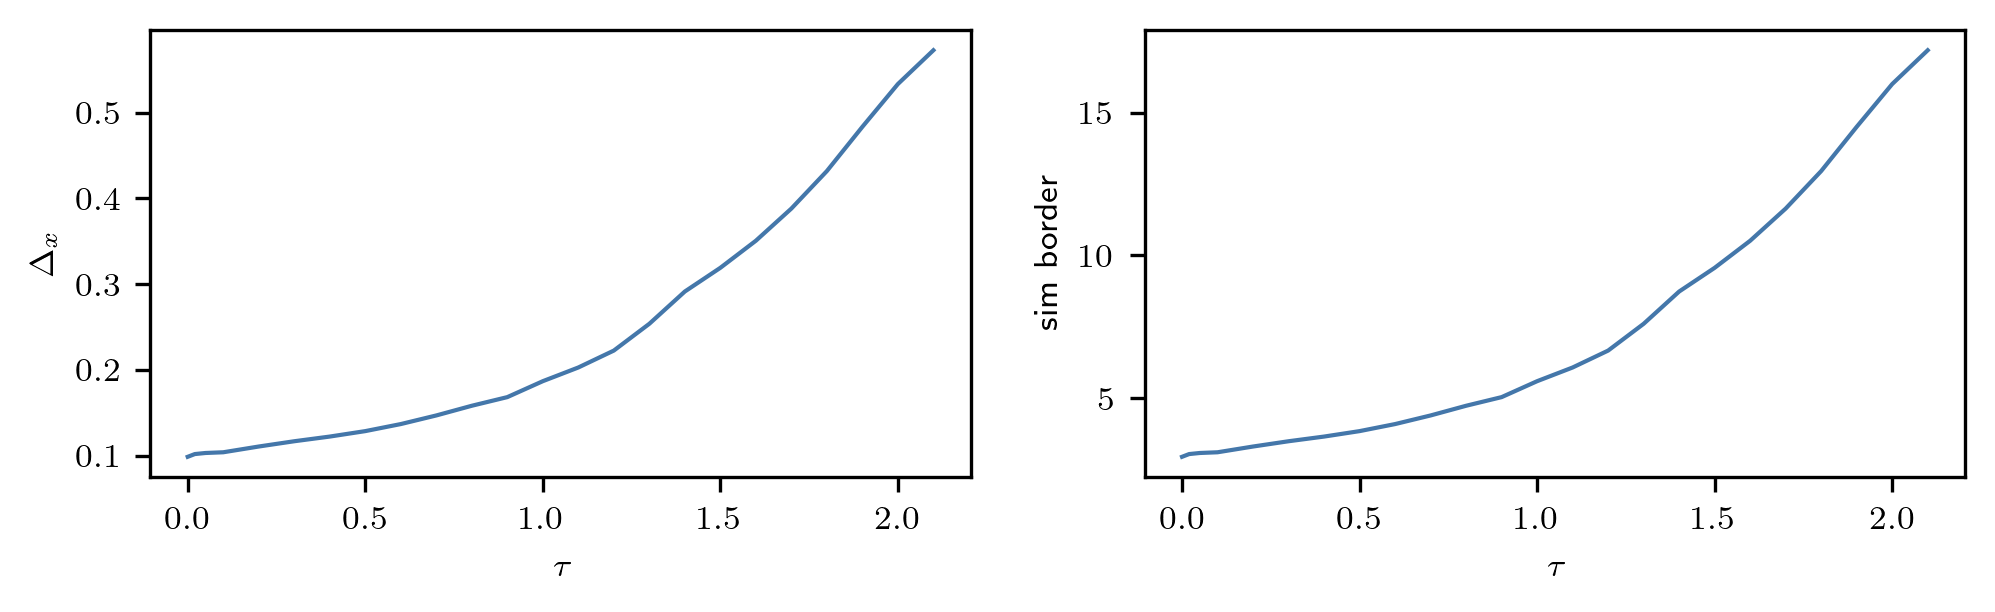

In [65]:
fig, axs = plt.subplots(1,2, figsize = (two_col, std_height))
axs[0].plot(ltaus, 2*sbs/(N_x-1))
axs[0].set_xlabel(r'$\tau$')
axs[0].set_ylabel(r'$\Delta_x$')

axs[1].plot(ltaus, sbs)
axs[1].set_xlabel(r'$\tau$')
axs[1].set_ylabel(r'sim border')

plt.tight_layout()